In [672]:
from random import *
from math import *
from copy import *
from statistics import mean 
from IPython.display import Image
import cairocffi as cairo
import pandas as pd
import numpy as np

## Visualisation tools

In [642]:
from dataclasses import dataclass

import cairocffi as cairo

@dataclass
class Vector2i():
    x: int = 0
    y: int = 0

class Visualizer():
    def __init__(self,
                 width=800,
                 height=800,
                 x_offset=0.1,
                 y_offset=0.1):
        self.height = height
        self.width = width
        self.x_offset = x_offset
        self.y_offset = y_offset
        self.surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, height, width)
        self.context = cairo.Context(self.surface)

    def draw_gantt(self, scheduler, filename, grid_draw = False):
        self._setup_canvas()
        max_time = self._setup_xaxis(scheduler.work_duration())
        num_servers = self._setup_yaxis(scheduler.server_count)
        width_scaling = self._scale_axis(self.x_offset, max_time)
        height_scaling = self._scale_axis(self.y_offset, num_servers)

        jobs_colors = {
            j_id: self._generate_color()
            for j_id in scheduler.job_ids()
        }

        ids = scheduler.server_ids()
        servers_ypos = {
            id: ypos
            for id, ypos in zip(ids, self._server_yposition(ids))
        }

        for task in scheduler.tasks:
            if type(task) is Power_off:
                r_col = 0
                g_col = 0
                b_col = 0
            else:
                j_id = task.job_id
                r_col = jobs_colors[j_id][0]
                g_col = jobs_colors[j_id][1]
                b_col = jobs_colors[j_id][2]
            t_time = task.end_time - task.start_time
            for server in task.servers:
                alpha = 0.5 if isinstance(task, Reconfiguration) else 1.0
                tl = Vector2i(self.x_offset + task.start_time * width_scaling,
                              servers_ypos[server.id])
                size = Vector2i(width_scaling * t_time, height_scaling)
                self._draw_rectangle(tl=tl,
                                     size=size,
                                     r=r_col,
                                     g=g_col,
                                     b=b_col,
                                     alpha=alpha)

        if (grid_draw):
            self._draw_grid(scheduler.work_duration(), num_servers)

        self.context.set_font_size(0.05)
        self._set_labels(xlabel="Time",
                         xlabel_pos=Vector2i(0.8, 0.97),
                         ylabel="Servers",
                         ylabel_pos=Vector2i(0, 0.07))
        self._save_to(filename)

    def _setup_canvas(self, height=800, width=800):
        self._normalize_canvas()
        self._draw_rectangle()

    def _normalize_canvas(self):
        self.context.scale(self.height, self.width)

    def _setup_xaxis(self, xmax):
        return 1.01 * xmax

    def _setup_yaxis(self, ymax):
        return ymax

    def _scale_axis(self, offset, max_value):
        return (1 - offset * 2) / max_value

    def _generate_color(self):
        return [random() for j in range(3)]

    def _server_yposition(self, servers):
        y_positions = []
        server_count = len(servers)
        height_scaling = self._scale_axis(self.y_offset, server_count)
        for i in range(server_count):
            y_positions.append(self.y_offset + i * height_scaling)
        return y_positions

    def _draw_rectangle(self,
                        tl=Vector2i(),
                        size=Vector2i(1,1),
                        r=1,
                        g=1,
                        b=1,
                        alpha=1.0):
        self.context.rectangle(tl.x, tl.y, size.x, size.y)
        self._set_color(r, g, b, alpha)
        self.context.fill()

    def _set_color(self, r=0, g=0, b=0, alpha=1.0):
        self.context.set_source_rgba(r, g, b, alpha)

    def _draw_grid(self, xmax, ymax):
        scaled_x = self._setup_xaxis(xmax)
        width_scaling = self._scale_axis(self.x_offset, scaled_x)
        height_scaling = self._scale_axis(self.y_offset, ymax)

        for i in range(ceil((xmax + 1)/1000)):
            pos = Vector2i(self.x_offset + (i * width_scaling)*1000, self.y_offset)
            self._move_cursor(pos)
            pos.y = 1 - pos.y
            self._draw_line(pos)

        for j in range(ymax + 1):
            pos = Vector2i(self.x_offset, self.y_offset + j * height_scaling)
            self._move_cursor(pos)
            pos.x += xmax
            self._draw_line(pos)

    def _move_cursor(self, position):
        self.context.move_to(position.x, position.y)

    def _draw_line(self, position, line_width=0.001, r=0, g=0, b=0, alpha=0.9):
        self.context.line_to(position.x, position.y)
        self._set_color(r, g, b, alpha)
        self.context.set_line_width(line_width)
        self.context.stroke()

    def _set_labels(self, xlabel, xlabel_pos, ylabel, ylabel_pos):
        self._move_cursor(xlabel_pos)
        self.context.show_text(xlabel)

        self._move_cursor(ylabel_pos)
        self.context.show_text(ylabel)

    def _save_to(self, filename):
        self.surface.write_to_png(filename)


## Objective:

minimize(max $\frac{t_{termination} - t_{submission}}{mass})$

## Job class
Initial parameters: <br>
- name : unique id of the job<br>
- sub_time: submission time<br>
- alpha : speed up factor (can be thought of as the communication time), should be somewhere between 0.5 and 1
- data: data to be processed, required for the reconfiguration time (see equation below)
- mass: mass of computation : area if run with one server 
- min_num_servers : minimum number of servers required for the job to be run
- max_num_servers : maximum number of servers the job should be run on
<br>



### Jobs and tasks
A job is broken into smaller tasks that can be processed on a different amount of servers. The number of servers used will impact the processing time according to the equation shown below.


### Processing time of a task
$time = \frac{mass}{(num\_servers)^{alpha}}$<br>
or<br>
$mass= time \times (num\_servers)^{alpha}$


### Reconfiguration time
Time required to reconfigure the data if the number of servers is either increased or decreased. <br>
if $n\geq m$:<br>
$T_{n\rightarrow m} = \frac{D}{n}(\lceil \frac{n}{m}\rceil - 1)$<br>
if $n\leq m$:<br>
$T_{n\rightarrow m} = \frac{D}{m}(\lceil \frac{m}{n}\rceil - 1)$<br>

where $D$ is the data amount in the application, $n$ number of servers in the previous process and $m$ the number of servers in the new process

In [643]:
class Job():
    def __init__(self, id, sub_time, alpha, data, mass, min_num_servers,
                 max_num_servers):
        self.id = id
        self.sub_time = sub_time
        self.alpha = alpha
        self.data = data
        self.mass = mass
        self.min_num_servers = min_num_servers
        self.max_num_servers = max_num_servers

    def __eq__(self, other):
        return self.id == other.id


## Task class
Initial parameters: <br>
- job_name: The job to which the task belongs
- start_time
- end_time
- mass_executed
- servers : list of servers the task is executed on

In [644]:
class Task(object):
    def __init__(self, job_id, mass_executed, servers, start_time, end_time):
        self.job_id = job_id
        self.mass_executed = mass_executed
        self.servers = servers
        self.start_time = start_time
        self.end_time = end_time

    def __repr__(self):
        return "name: {}, mass_exec: {}, #servers: {} start_time: {}, end_time: {}".format(
            self.job_id, self.mass_executed, len(self.servers),
            self.start_time, self.end_time)

    def from_job(self, job):
        return self.job_id == job.id



class Reconfiguration(Task):
    def __init__(self, job_id, servers, start_time, end_time):
        Task.__init__(self, job_id, 0, servers, start_time, end_time)

    def __str__(self):
        return "name: {}, reconfiguration, mass_exec: {}, #servers: {} start_time: {}, end_time: {}".format(
            self.job_id, self.mass_executed, len(self.servers),
            self.start_time, self.end_time)

class Power_off(Task):
    def __init__(self, servers, start_time, end_time):
        Task.__init__(self, "power off", 0, servers, start_time, end_time)
    def __str__(self):
        return "Power off, #servers: {} start_time: {}, end_time: {}".format(
            len(self.servers), self.start_time, self.end_time)

## Server

A server is a computation unit 

In [645]:
class Server():
    def __init__(self, id):
        self.id = id

    def __eq__(self, other):
        return self.id == other.id


## Energy


values from Poquet 2017, batsim phd thesis <br>
Energy notes:<br>
Energy is saved by turning off and back on computer compared to idle state if the time off is at least 230s, meaning a total time to switch off + off time + starting time is at least 362s


In [646]:
class Energy():
    def power_idle(self):
        return 95
    
    def energy_idle(self, time):
        return self.power_idle()*time
    
    def energy_computing(self,time):
        return 191*time
    
    def power_off_on(self):
        return 125
    
    def time_off_on(self):
        return 151
    
    def power_on_off(self):
        return 101
    
    def time_on_off(self):
        return 6
    
    def power_off(self):
        return 10
    
    def energy_off(self, time):
        off_time = time - self.time_off_on() - self.time_on_off()
        energy = self.power_off_on() * self.time_off_on() + self.power_on_off() * self.time_on_off() 
        energy = energy + off_time * self.power_off()
        return energy

## Scheduler - state of whole thing

Manager should be able to access objects and query.<br>

In [685]:
class Scheduler(object):
    def __init__(self, servers):
        self.servers = servers
        self.jobs = []
        self.tasks = []
        self.job_queued = []
        # tuning parameters
        self.server_threshold = 0.7
        self.estimated_improv_threshold = 0.9 #ratio of the remaining time of the reconfigured to the original time
        self.ratio_almost_finished_jobs = 0.8
        
        self.time_remaining_for_power_off = 370
        self.shut_down_time = 800
        #Cost function weights
        self.stretch_time_weight = 1
        self.energy_weight = 1
        
        
    def schedule1(self, job):
        self.jobs.append(job)
        self.job_queued.append(job)
        self.update_schedule1(job.sub_time)
    
    def update_schedule1(self, time):
        if self._is_ratio_available_servers_above_threshold(time):
            while self.job_queued:
                self._order_queue_by_sub_time()
                job_to_sched = self.job_queued[0]
                num_servers_to_use = self._num_server_alloc(job_to_sched, time)
                if num_servers_to_use > 0:
                    available_servers = self._available_servers(time)
                    self._schedule_task_given_num_servers(num_servers_to_use, available_servers, job_to_sched, time)
                    self.job_queued.remove(job_to_sched)
                else:
                    break
                if self._is_ratio_available_servers_above_threshold(time):
                    break
        
        if self._is_ratio_available_servers_above_threshold(time):     
            #order job by remaining mass
            jobs_by_mass = self._jobs_by_mass_remaining(time)
            while jobs_by_mass:
                job_reconfig = jobs_by_mass[0]
                if self._is_job_reconfigurable(job_reconfig, time):
                    task_to_reconfig = self._current_task_of_job(job_reconfig, time)
                    self._reconfigure_task(task_to_reconfig, time)
                    jobs_by_mass.remove(job_reconfig)
                if self._is_ratio_available_servers_above_threshold(time):
                    break
                
        if  self._num_available_servers(time)!=0 and not self._is_ratio_available_servers_above_threshold(time):
            num_jobs_currently_executed = 0
            num_jobs_finishing_under_threshold_time = 0
            for job in self.jobs:
                job_termination_time = self._job_termination_time(job)
                if job_termination_time > time:
                    num_jobs_currently_executed += 1
                    time_remaining = job_termination_time - time
                    if time_remaining < self.time_remaining_for_power_off:
                        num_jobs_finishing_under_threshold_time += 1
            if num_jobs_currently_executed > 0 and num_jobs_finishing_under_threshold_time/num_jobs_currently_executed >= self.ratio_almost_finished_jobs:
                available_servers = self._available_servers(time)
                self.turn_off_servers(available_servers, time)
                    
            
    ############################################
    # Reconfigure a job if possible
    
    def schedule_simple(self, job):
        self.jobs.append(job)

        #schedule the first job into one task
        if len(self.tasks) == 0:
            self._schedule_task(self.servers, job, job.sub_time)
        #Schedule the jobs
        else:
            #Get the servers available at submission time
            available_servers = self._available_servers(job.sub_time)
            if (len(available_servers) < job.min_num_servers):
                self.job_queued.append(job)
                return
            #Schedule task
            else:
                self._schedule_task(available_servers, job, job.sub_time)

    def update_schedule_simple(self, time):
        #get the free servers
        available_servers = self._available_servers(time + 0.01)
        num_available_servers = len(available_servers)

        #print('Number of available servers at update: ', num_available_servers)

        #Check if there is job queued
        if (self.job_queued):
            #Try to schedule each job
            for job in self.job_queued:
                if (num_available_servers > job.min_num_servers):
                    self._schedule_task(available_servers, job, time)
                    #remove job from queue
                    self.job_queued.remove(job)
                    #update list of servers available
                    available_servers = self._available_servers(time + 0.01)
                    num_available_servers = len(available_servers)

        #find tasks that could be reconfigured
        #List of tasks for which the possible change of the number of servers is greater than 0
        tasks_candidates = [
            t for t in self.tasks if
            self._task_possible_inc_num_ser(t, time, num_available_servers) > 0
        ]

        if (len(tasks_candidates) == 0):
            return

        task_to_reconfig = tasks_candidates[0]
        self._reconfigure_task(task_to_reconfig, time)

    def _reconfigure_task(self, task, time):
            available_servers = self._available_servers(time + 0.01)
            num_available_servers = len(available_servers)
            # Return the list of new servers to execute the task
            def reallocate_task_servers(task):
                extra_srv_count = self._task_possible_inc_num_ser(
                    task, time, num_available_servers)
                task_servers = [s for s in task.servers]
                for i in range(extra_srv_count):
                    task_servers.append(available_servers[i])
                return task_servers

            # Reconfigure and update the task
            # Update the task end_time and mass_executed.
            def interrupt_task(task, job):
                task.end_time = time
                exec_time = task.end_time - task.start_time
                task.mass_executed = self._mass_exec(job.alpha,
                                                     len(task.servers),
                                                     exec_time)

        #Create a new task for reconfiguration

            def make_reconfiguration(job, servers):
                reconfig_time = self._reconfig_time(job.data,
                                                    len(task.servers),
                                                    len(servers))
                reconfig_end_time = time + reconfig_time
                reconfig = Reconfiguration(job.id, servers, time,
                                           reconfig_end_time)
                self.tasks.append(reconfig)
                return reconfig

            # Create a task to finish job after reconfig
            def reschedule_interrupted(job, reconfig, servers):
                mass_left = job.mass - self._mass_executed(job, time)
                exec_time = self._exec_time(mass_left, job.alpha, len(servers))
                start_time = reconfig.end_time
                end_time = reconfig.end_time + exec_time
                mass_executed = mass_left
                self.tasks.append(
                    Task(job.id, mass_executed, servers, start_time, end_time))

            task_job = self._task_job(task)
            task_servers = reallocate_task_servers(task)
            interrupt_task(task, task_job)
            reconfig = make_reconfiguration(task_job, task_servers)
            reschedule_interrupted(task_job, reconfig, task_servers)
    
    def turn_off_servers(self, servers, time):
        self.tasks.append(Power_off(servers, time, time+self.shut_down_time))
            
    #################################################################
    def _is_job_reconfigurable(self, job, time):
        #print(job.id)
        if abs(job.sub_time - time) < 0.001:
            return False      
        remaining_time = self._job_termination_time(job) - time
        #task to reconfigure
        task = self._current_task_of_job(job, time)
        if task is None or type(task) is Reconfiguration:
            return False
        #estimate exec time if task is reconfigured
        current_srv_count = len(task.servers)
        extra_srv_count = self._task_possible_inc_num_ser(
                    task, time, self._num_available_servers(time))
        new_srv_count = current_srv_count + extra_srv_count
        # Reconfiguration time
        reconfig_time = self._reconfig_time(job.data,
                                                    current_srv_count,
                                                    new_srv_count)
        
        #Mass remaining to execute until time
        mass_left = task.mass_executed - self._mass_exec(job.alpha,len(task.servers), time - task.start_time)
        
        #execution time on new srv count
        exec_time = self._exec_time(mass_left, job.alpha, new_srv_count)
        if (reconfig_time + exec_time) / remaining_time < self.estimated_improv_threshold :
            return True
        else:
            return False
        
    def _current_task_of_job(self, job, time):
        for t in self.tasks:
            if time > t.start_time and time < t.end_time and t.job_id == job.id:
                return t
    
    def _job_termination_time(self, job):
        term_time = -1
        for t in self.tasks:
            if t.job_id == job.id and t.end_time > term_time:
                term_time = t.end_time
        return term_time
    
    def _job_start_time(self, job):
        start_time = inf
        for t in self.tasks:
            if t.job_id == job.id and t.start_time < start_time:
                start_time = t.start_time
        return start_time
    
    ######## Can be probably tuned as well #################
    def _num_server_alloc(self, job, time):
        num_available_servers = self._num_available_servers(time)
        if job.alpha > 0.75 :
            return min(job.max_num_servers, num_available_servers)
        elif job.alpha > 0.65:
            return min(4, job.max_num_servers, num_available_servers)
        else:
            return min(2,job.max_num_servers, num_available_servers)
    
    def _order_queue_by_sub_time(self):
        self.job_queued = sorted(self.job_queued, key=lambda k: k.sub_time) 
    
    
    def _is_ratio_available_servers_above_threshold(self, time):
        if self._ratio_available_servers(time) > self.server_threshold:
            return True
        else:
            return False
    
    def _ratio_available_servers(self, time):
        return len(self._available_servers(time))/len(self.servers)
    
    def _num_available_servers(self,time):
        return len(self._available_servers(time))
    
    # returns a list of servers not utilized at a given time
    def _available_servers(self, time):
        #Start with all servers as potential servers
        candidate_servers = [s for s in servers]
        #remove servers that are busy at the given time
        for t in self.tasks:
            if not (t.start_time <= time and t.end_time > time):
                continue
            for s in t.servers:
                if s in candidate_servers:
                    candidate_servers.remove(s)
        return candidate_servers
    
    def _schedule_task_given_num_servers(self, num_servers, servers, job, time):
        servers_selec = sample(servers, k=num_servers)
        exec_time = self._exec_time(job.mass, job.alpha, num_servers)
        self.tasks.append(
            Task(job.id, job.mass, servers_selec, time, time + exec_time))
    
    def _schedule_task(self, servers, job, time):
        num_servers = min(job.max_num_servers, len(servers))
        servers = sample(servers, k=num_servers)
        exec_time = self._exec_time(job.mass, job.alpha, num_servers)
        self.tasks.append(
            Task(job.id, job.mass, servers, time, time + exec_time))

    # Returns the possible increase in the number of servers for a task
    # given that num_servers are not busy
    def _task_possible_inc_num_ser(self, task, time, num_servers):
        #job = list(filter(lambda j: (j.id == task.job_id), self.jobs))[0]
        if (task.end_time <= time):
            return 0
        job = next(j for j in self.jobs if (j.id == task.job_id))
        task_num_servers = len(task.servers)
        if (task_num_servers == job.max_num_servers):
            return 0
        elif (task_num_servers + num_servers > job.max_num_servers):
            return job.max_num_servers - task_num_servers
        else:
            return num_servers

    # Formula for communication time
    def _mass_exec(self, alpha, num_serv, exec_time):
        return exec_time * (num_serv)**alpha

    def _exec_time(self, mass, alpha, num_serv):
        return mass / (num_serv)**alpha

    #Calculates the reconfiguration time
    def _reconfig_time(self, data, init_servers, final_servers):
        if init_servers > final_servers:
            return data / init_servers * (ceil(init_servers / final_servers) -
                                          1)
        return data / final_servers * (ceil(final_servers / init_servers) - 1)

    
    ############################################################
    def _jobs_by_mass_remaining(self, time):
        jobs_by_mass = []
        for j in self.jobs:
            if j.sub_time < time:
                m = self._mass_remaining(j, time)
                if m > 0:
                    jobs_by_mass.append([j,m])
        jobs_by_mass = sorted(jobs_by_mass, key=lambda k: k[1], reverse=True) 
        return [j[0] for j in jobs_by_mass]
    
    def _mass_remaining(self, job, time):
        return job.mass - self._mass_executed_at_time(job, time)
    
    #Finds how much mass has been executing of job at time t
    def _mass_executed_at_time(self, job, time):
        mass_ex = 0
        for t in self.tasks:
            if t.job_id == job.id:
                if t.end_time <= time:
                    mass_ex += t.mass_executed
                else:
                    mass_ex += t.mass_executed - self._mass_exec(job.alpha,len(t.servers), time - t.start_time)
        return mass_ex

    #Finds how much mass has been executing of job
    def _mass_executed(self, job, time):
        mass_ex = 0
        for t in self.tasks:
            if t.job_id == job.id:
                mass_ex += t.mass_executed
        return mass_ex

    # Returns the makespan
    def work_duration(self):
        min_time = min([t.start_time for t in self.tasks])
        max_time = max([t.end_time for t in self.tasks])
        return max_time - min_time

    def job_ids(self):
        return [j.id for j in self.jobs]

    def server_ids(self):  # server_id_list
        return [s.id for s in self.servers]

    @property
    def server_count(self):
        return len(self.servers)

    #Returns the job that a task is executing
    def _task_job(self, task):
        return next(j for j in self.jobs if task.from_job(j))
    
    def stretch_time(self, job):
        #find the termination time from the tasks of that job and subtime, divide the difference by the mass
        term_time = -1
        for t in self.tasks:
            if t.job_id == job.id and t.end_time > term_time:
                term_time = t.end_time
        return (term_time - job.sub_time) / job.mass

    def stretch_times(self):
        #array of all the stretch times
        return [self.stretch_time(j) for j in self.jobs]

    def average_stretch_time(self):
        return mean(self.stretch_times())

    def max_stretch_time(self):
        return max(self.stretch_times())
    
    def average_power(self):
        work_duration = self.work_duration()
        serv_count = len(self.servers)
        total_energy = 0
        area = 0
        energy_calc = Energy()
        for task in self.tasks:
            task_duration = task.end_time - task.start_time
            task_num_servers = len(task.servers)
            if type(task) is Power_off:
                total_energy = total_energy + energy_calc.energy_off(task_duration) * task_num_servers
            else:
                total_energy = total_energy + energy_calc.energy_computing(task_duration) * task_num_servers
            area = area + task_duration * task_num_servers
        #adding idle time
        energy_idle = (work_duration * serv_count - area) * energy_calc.power_idle()
        total_energy = total_energy + energy_idle
        return total_energy
    
    def normalized_average_power(self):
        work_duration = self.work_duration()
        serv_count = len(self.servers)
        energy_calc = Energy()
        idle_power = work_duration * serv_count * energy_calc.power_idle()
        return self.average_power() / idle_power
    
    def num_reconfig_task(self):
        num = 0
        for t in self.tasks:
            if type(t) is Reconfiguration:
                num = num + 1
        return num
    
    def num_power_off(self):
        num = 0
        for t in self.tasks:
            if type(t) is Power_off:
                num = num + 1
        return num
    
    def cost_function(self):
        return self.stretch_time_weight * self.average_stretch_time() + self.energy_weight * self.normalized_average_power()
    
    def summary(self):
        print("Number of servers: {}".format(len(self.servers)))
        print("Number of jobs scheduled: {}".format(len(self.jobs)))
        print("Number of reconfigurations: {}".format(self.num_reconfig_task()))
        print("Number of power offs: {}".format(self.num_power_off()))
        print("Total work time: {}".format(self.work_duration()))
        print("Cost function value: {}".format(self.cost_function()))
        
    def stats(self):
        #num reconfig, num power off, min stretch, max stretch, mean stretch, std stretch, av power, cost function
        stretch_times = np.array(self.stretch_times())
        stats = np.array([self.num_reconfig_task(), self.num_power_off(), np.min(stretch_times), np.max(stretch_times), np.mean(stretch_times), np.std(stretch_times), self.normalized_average_power(), self.cost_function()])
        return stats

Instantiating the different jobs to be processed and servers

In [686]:
job1 = Job('job1', sub_time = 0, alpha = 1, data = 10, mass = 10000, min_num_servers = 2, max_num_servers=3)
job2 = Job('job2', sub_time = 1, alpha = 1, data = 10, mass = 20000, min_num_servers = 1, max_num_servers=4)
job3 = Job('job3', sub_time = 6, alpha = 0.5, data = 3, mass = 15000, min_num_servers = 1, max_num_servers=5)
job4 = Job('job4', sub_time = 12, alpha = 0.9, data = 10, mass = 35000, min_num_servers = 1, max_num_servers=4)
jobs = [job1,job2, job3, job4]
#Sort jobs by submission time
jobs = sorted(jobs, key=lambda k: k.sub_time) 

servers = [Server('server'+str(i)) for i in range(6)]

In [687]:
seed(2)
def generate_job(num):
    sub_time = uniform(0,5000)
    alpha = uniform(0.5,1)
    data = uniform(10,1000)
    mass = uniform(10, 50000)
    min_num_servers = randrange(1,9)
    max_num_servers = randrange(min_num_servers,10)
    return Job('job' + str(num), sub_time, alpha, data, mass, min_num_servers, max_num_servers)

jobs = [generate_job(i) for i in range(40)]
jobs = sorted(jobs, key=lambda k: k.sub_time) 
servers = [Server('server'+str(i)) for i in range(10)]

Initialize the scheduler

In [688]:
scheduler = Scheduler(servers)

In [689]:
for t in range(25000):
    time = t * 10
    #print('time: ', time)
    for job in jobs:
        if job.sub_time<=time:
            #print('scheduling job:', job.id)
            scheduler.schedule1(job)
            jobs.remove(job)
        else:
            break
    scheduler.update_schedule1(time)
    
for task in scheduler.tasks:
    print(task)


name: job35, mass_exec: 15303.058811706182, #servers: 8 start_time: 95.27552404802297, end_time: 2748.565099600822
Power off, #servers: 2 start_time: 2380, end_time: 3180
name: job17, mass_exec: 6398.07883619953, #servers: 8 start_time: 2750, end_time: 3620.365766576523
Power off, #servers: 2 start_time: 3260, end_time: 4060
name: job25, mass_exec: 4802.638462222828, #servers: 2 start_time: 3629.746437386491, end_time: 6986.459189536701
name: job36, mass_exec: 44478.19988266651, #servers: 2 start_time: 3629.746437386491, end_time: 28847.696326865695
name: job38, mass_exec: 6991.868908341892, #servers: 4 start_time: 3629.746437386491, end_time: 6328.482043516502
name: job29, mass_exec: 5104.542891067686, #servers: 3 start_time: 6990, end_time: 9214.506422111599
name: job5, mass_exec: 17990.9732757821, #servers: 2 start_time: 6990, end_time: 18968.762372276375
name: job18, mass_exec: 2167.6181799169913, #servers: 3 start_time: 6990, end_time: 7845.970061076851
name: job27, mass_exec: 400

In [690]:
scheduler.summary()
scheduler.stats()

Number of servers: 10
Number of jobs scheduled: 40
Number of reconfigurations: 1
Number of power offs: 6
Total work time: 183454.72447595198
Cost function value: 6.530755526575651


array([ 1.        ,  6.        ,  0.17338296, 34.62724572,  4.90456048,
        5.76463207,  1.62619504,  6.53075553])

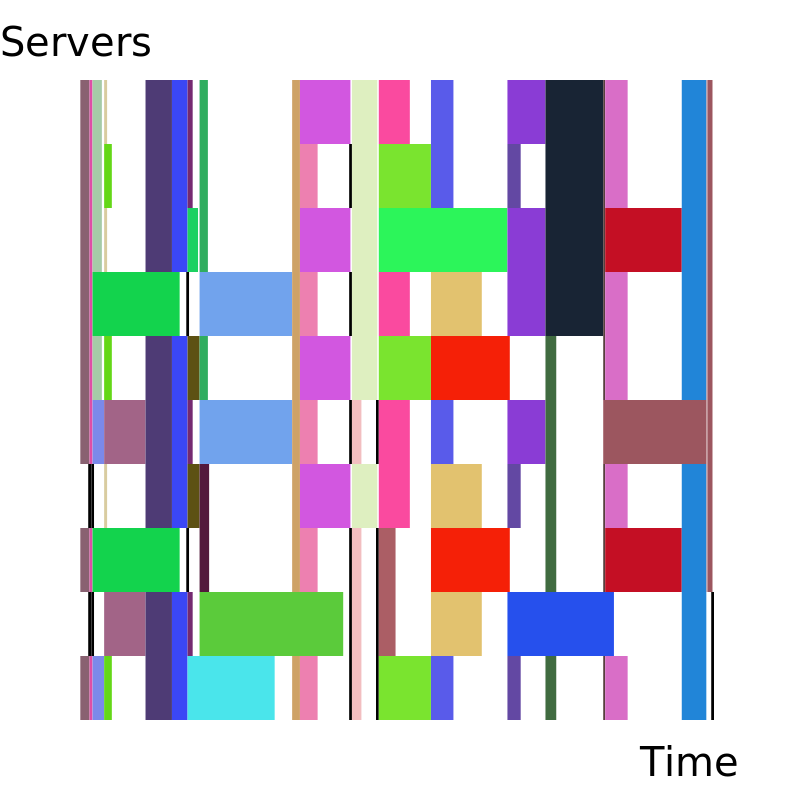

In [691]:
vz = Visualizer(width=800, height=800)
file_name = 'test_2.png'
vz.draw_gantt(scheduler, file_name)
Image(filename = file_name, width=500, height=500)

In [709]:
class Experiments():
    def __init__(self, num_expts):
        self.num_expts = num_expts
        seed = 0
        self.cols = ["num reconfig", "num power off", "min stretch", "max stretch", "mean stretch", "std stretch", "av power", "cost function"]
        self.stats = pd.DataFrame(columns=self.cols)
        
    def generate_job(self, num):
        sub_time = uniform(0,5000)
        alpha = uniform(0.5,1)
        data = uniform(10,1000)
        mass = uniform(10, 50000)
        min_num_servers = randrange(1,9)
        max_num_servers = randrange(min_num_servers,10)
        return Job('job' + str(num), sub_time, alpha, data, mass, min_num_servers, max_num_servers)

    def generate_jobs(self):
        jobs = [self.generate_job(i) for i in range(40)]
        jobs = sorted(jobs, key=lambda k: k.sub_time) 
        return jobs
    
    def generate_servers(self):
        servers = [Server('server'+str(i)) for i in range(10)]
        return servers
    
    def generate_scheduler(self):
        scheduler = Scheduler(self.generate_servers())
        return scheduler
    
    def run_expt(self):
        jobs = self.generate_jobs()
        scheduler = self.generate_scheduler()
        for t in range(25000):
            time = t * 10
            for job in jobs:
                if job.sub_time<=time:
                    scheduler.schedule1(job)
                    jobs.remove(job)
                else:
                    break
            scheduler.update_schedule1(time)
        expt_stats = pd.DataFrame([scheduler.stats()], columns=self.cols)
        self.stats = pd.concat([self.stats, expt_stats])
    
    def run_expts(self):
        for i in range (self.num_expts):
            self.run_expt()
    
    def get_stats(self):
        return self.stats

In [711]:
experiments = Experiments(25)
experiments.run_expts()
print(experiments.get_stats())

   num reconfig  num power off  min stretch  max stretch  mean stretch  \
0           2.0           11.0     0.409791   178.235009     10.432534   
0           1.0            4.0     0.211059   194.512316     17.213923   
0           0.0            4.0     0.165914    98.980590      7.554153   
0           1.0            6.0     0.132635    47.278929      7.314402   
0           1.0            6.0     0.173473    98.285536      8.422226   
0           2.0            6.0     0.414368   124.912998     10.131605   
0           1.0            4.0     0.430806    41.334879      9.057084   
0           1.0           10.0     0.292529   967.512744     34.754412   
0           2.0            5.0     0.377022    66.625069      9.737123   
0           0.0           11.0     0.362679   119.531537     13.088304   
0           2.0            7.0     0.301113   313.545226     14.091241   
0           1.0            4.0     0.129934   318.941069     15.150915   
0           2.0            9.0     0.2

In [692]:
scheduler_simple = Scheduler(servers)
for t in range(25000):
    time = t * 10
    #print('time: ', t)
    for job in jobs:
        if job.sub_time<=time:
            #print('scheduling job:', job.id)
            scheduler_simple.schedule_simple(job)
            jobs.remove(job)
        else:
            break
    scheduler_simple.update_schedule_simple(time)
    
for task in scheduler_simple.tasks:
    print(task)


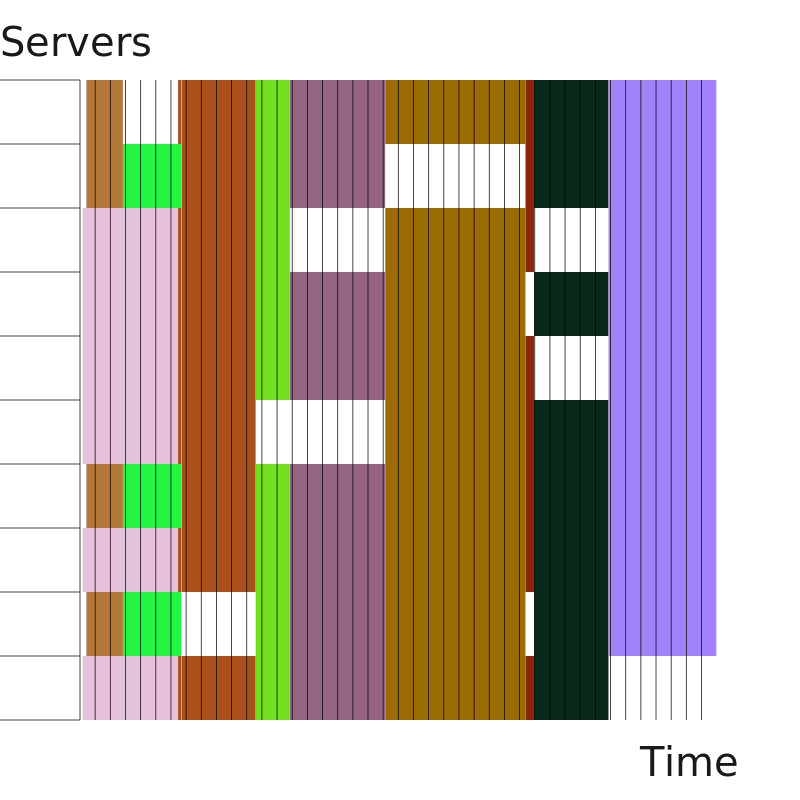

In [567]:
vz = Visualizer(width=800, height=800)
file_name = 'test_2.png'
vz.draw_gantt(scheduler_simple, file_name)
Image(filename = file_name, width=500, height=500)

In [568]:
scheduler_simple.average_stretch_time()

1.1966925365067291

In [569]:
print(scheduler_simple.average_stretch_time())
print(scheduler_simple.normalized_average_power())
print(scheduler_simple.cost_function())

1.1966925365067291
1.8846795801291523
3.0813721166358814
